## EDA
### Install packages

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.3.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.7.22          |  py310h06a4308_0         153 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/

### Build Spark Session

In [3]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-43ab76e7-ac3e-4a26-b2e5-c23e5ae068dd;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 400ms :: artifacts dl 37ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

23/11/06 21:54:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


3.3.0


### Read filtered dataset and basic information check

In [4]:
%%time

import time
import sagemaker

bucket = "dsan-6000-group-35"
output_prefix_data_submissions = f"/submissions.parquet"
s3_path = f"s3a://{bucket}/{output_prefix_data_submissions}"

print(f"reading submissions from {s3_path}")
submissions = spark.read.parquet(s3_path, header=True)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
reading submissions from s3a://dsan-6000-group-35//submissions.parquet
23/11/06 21:55:07 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


CPU times: user 2.41 s, sys: 244 ms, total: 2.65 s
Wall time: 11.5 s


In [5]:
%%time
output_prefix_data_comments = "comments.parquet"
s3_path = f"s3a://{bucket}/{output_prefix_data_comments}"
print(f"reading comments from {s3_path}")
comments = spark.read.parquet(s3_path, header=True)

reading comments from s3a://dsan-6000-group-35/comments.parquet
CPU times: user 2.91 ms, sys: 1.24 ms, total: 4.16 ms
Wall time: 1.05 s


In [6]:
print(f"shape of the submissions dataframe is {submissions.count():,}x{len(submissions.columns)}")

shape of the submissions dataframe is 391,059x12


In [8]:
submissions.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- text: string (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- num_crossposts: long (nullable = true)
 |-- score: long (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- stickied: boolean (nullable = true)



In [9]:
print(f"shape of the comments dataframe is {comments.count():,}x{len(comments.columns)}")

shape of the comments dataframe is 5,750,926x12


In [10]:
comments.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- body: string (nullable = true)
 |-- score: long (nullable = true)
 |-- gilded: long (nullable = true)
 |-- controversiality: long (nullable = true)



In [11]:
import pyspark.sql.functions as f

## Data quality check

First take a look at the dataframe, some columns included values like **deleted** and **removed** which can be considered as missing values, which should be removed from rows

In [12]:
submissions.show(10)

+----+-----+---------+------+--------------------+-------------------+--------------------+------------+--------------+-----+-------+--------+
|year|month|subreddit|    id|              author|        created_utc|                text|num_comments|num_crossposts|score|is_self|stickied|
+----+-----+---------+------+--------------------+-------------------+--------------------+------------+--------------+-----+-------+--------+
|2021|    6|    Music|o2omjb|     the_dionysian_1|2021-06-18 13:03:18|Bo Burnham - Welc...|        1656|             2|20968|  false|   false|
|2021|    6|    Music|o2onm6|       Seismic_Noise|2021-06-18 13:04:51|LIQUERUS Resident...|           0|             0|    2|  false|   false|
|2021|    6|    Music|o2oop3|SteveNewmanGuitarist|2021-06-18 13:06:31|Steve Newman - Rd...|           0|             0|    1|  false|   false|
|2021|    6|    Music|o2op0p|         Zoinksbeats|2021-06-18 13:07:01|(FREE) Playboi Ca...|           1|             0|    1|  false|   false|

In [13]:
comments.show(10)

+----+-----+-----------+-------+--------------+---------+----------+-------------------+--------------------+-----+------+----------------+
|year|month|  subreddit|     id|        author|  link_id| parent_id|        created_utc|                body|score|gilded|controversiality|
+----+-----+-----------+-------+--------------+---------+----------+-------------------+--------------------+-----+------+----------------+
|2022|   10|TaylorSwift|irf7cfk|realscoutfinch|t3_xwui3g|t1_iracq55|2022-10-07 16:46:13|This this this! I...|    1|     0|               0|
|2022|   10|      Music|irf7cqw|    Alouitious|t3_xxz930|t1_irf6yfd|2022-10-07 16:46:17|4. Once you've bu...|    4|     0|               0|
|2022|   10|      Music|irf7dpm| ToastedSimian|t3_xy1kr4|t1_ireuzta|2022-10-07 16:46:29|Sadly, I'm a work...|    1|     0|               0|
|2022|   10|      Music|irf7drt|    tommykiddo|t3_xxz930|t1_irf39w8|2022-10-07 16:46:30|Ultimate Guitar h...|    3|     0|               0|
|2022|   10|      Mu

In [39]:
from pyspark.sql.functions import col, lower
from pyspark.sql import functions as F
from pyspark.sql.types import DateType
import pandas as pd
import matplotlib.pyplot as plt

# Filter for mentions of Taylor Swift in submissions and comments
taylor_swift_submissions = submissions.filter(lower(col("text")).like("%taylor swift%"))
taylor_swift_comments = comments.filter(lower(col("body")).like("%taylor swift%"))

# Count the mentions over time
ts_mentions_by_month_submissions = taylor_swift_submissions.groupBy("year", "month").count()
ts_mentions_by_month_comments = taylor_swift_comments.groupBy("year", "month").count()


In [34]:
# Truncate the timestamp to the date for submissions
taylor_swift_submissions = taylor_swift_submissions.withColumn('date', F.date_trunc('day', F.col('created_utc')))

# Truncate the timestamp to the date for comments
taylor_swift_comments = taylor_swift_comments.withColumn('date', F.date_trunc('day', F.col('created_utc')))

# Group by the truncated date column and count the mentions for submissions
ts_mentions_by_day_submissions = taylor_swift_submissions.groupBy('date').count()

# Group by the truncated date column and count the mentions for comments
ts_mentions_by_day_comments = taylor_swift_comments.groupBy('date').count()

# Collect the data to Pandas DataFrames for plotting
ts_mentions_by_day_submissions_pd = ts_mentions_by_day_submissions.toPandas()
ts_mentions_by_day_comments_pd = ts_mentions_by_day_comments.toPandas()

# Ensure the data is sorted by date
ts_mentions_by_day_submissions_pd = ts_mentions_by_day_submissions_pd.sort_values(by='date')
ts_mentions_by_day_comments_pd = ts_mentions_by_day_comments_pd.sort_values(by='date')




In [43]:
import os

current_directory = os.getcwd()
print("Current directory:", current_directory)


Current directory: /root/fall-2023-reddit-project-team-35/code


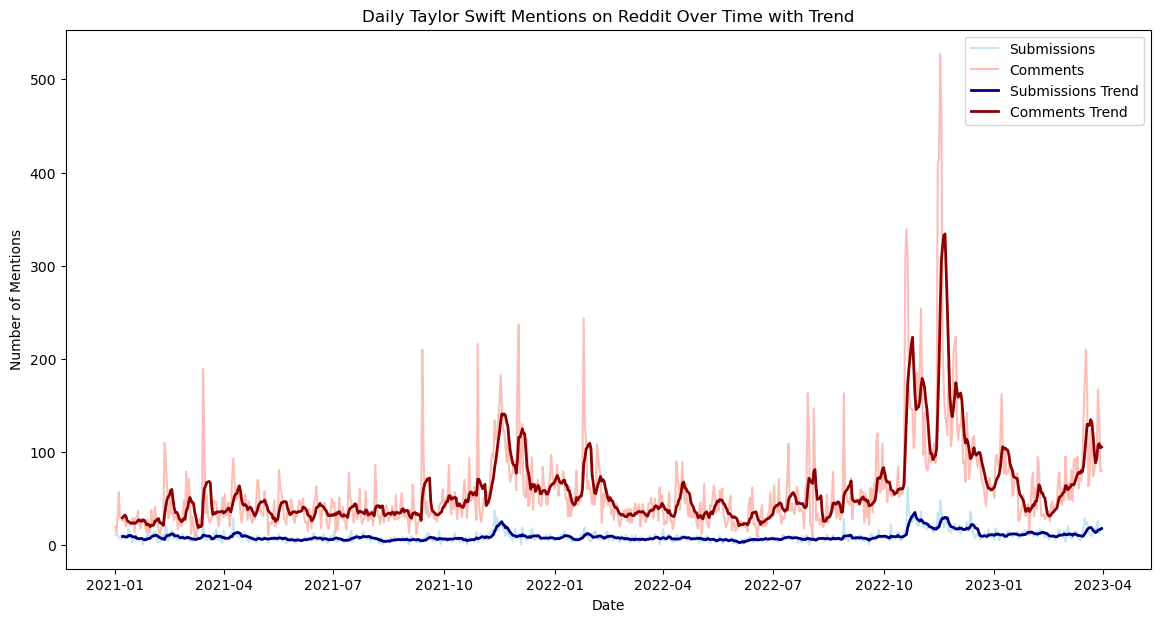

In [54]:
window_size = 7  # Example for a weekly trend

ts_mentions_by_day_submissions_pd['rolling_mean_submissions'] = ts_mentions_by_day_submissions_pd['count'].rolling(window=window_size).mean()
ts_mentions_by_day_comments_pd['rolling_mean_comments'] = ts_mentions_by_day_comments_pd['count'].rolling(window=window_size).mean()

# Re-plot the original data with semi-transparency
plt.figure(figsize=(14,7))
plt.plot(ts_mentions_by_day_submissions_pd['date'], ts_mentions_by_day_submissions_pd['count'], label='Submissions', alpha=0.5, color='skyblue')
plt.plot(ts_mentions_by_day_comments_pd['date'], ts_mentions_by_day_comments_pd['count'], label='Comments', alpha=0.5, color='salmon')

# Overlay the trend lines with more prominent colors and line styles
plt.plot(ts_mentions_by_day_submissions_pd['date'], ts_mentions_by_day_submissions_pd['rolling_mean_submissions'], label='Submissions Trend', color='navy', linestyle='-', linewidth=2)
plt.plot(ts_mentions_by_day_comments_pd['date'], ts_mentions_by_day_comments_pd['rolling_mean_comments'], label='Comments Trend', color='darkred', linestyle='-', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Number of Mentions')
plt.title('Daily Taylor Swift Mentions on Reddit Over Time with Trend')
plt.legend()
plt.savefig('../data/plots/mengfei_eda_taylor_swift_mentions_daily_with_trends.png', dpi=300, bbox_inches='tight')
plt.show()

In [47]:
ts_mentions_by_month_submissions_pd = ts_mentions_by_month_submissions.toPandas()
ts_mentions_by_month_comments_pd = ts_mentions_by_month_comments.toPandas()

In [48]:
import pandas as pd

# Example data, replace these with your actual DataFrames
# ts_mentions_by_month_submissions_pd = your DataFrame for submissions
# ts_mentions_by_month_comments_pd = your DataFrame for comments

# Ensure DataFrames are sorted by year and then month
ts_mentions_by_month_submissions_pd = ts_mentions_by_month_submissions_pd.sort_values(by=['year', 'month'])
ts_mentions_by_month_comments_pd = ts_mentions_by_month_comments_pd.sort_values(by=['year', 'month'])

# Combine 'year' and 'month' into a 'date' column for submissions
ts_mentions_by_month_submissions_pd['date'] = pd.to_datetime(ts_mentions_by_month_submissions_pd['year'].astype(str) + '-' +
                                                             ts_mentions_by_month_submissions_pd['month'].astype(str) + '-01')

# Combine 'year' and 'month' into a 'date' column for comments
ts_mentions_by_month_comments_pd['date'] = pd.to_datetime(ts_mentions_by_month_comments_pd['year'].astype(str) + '-' +
                                                          ts_mentions_by_month_comments_pd['month'].astype(str) + '-01')

# Now your DataFrames have a 'date' column which you can use for plotting


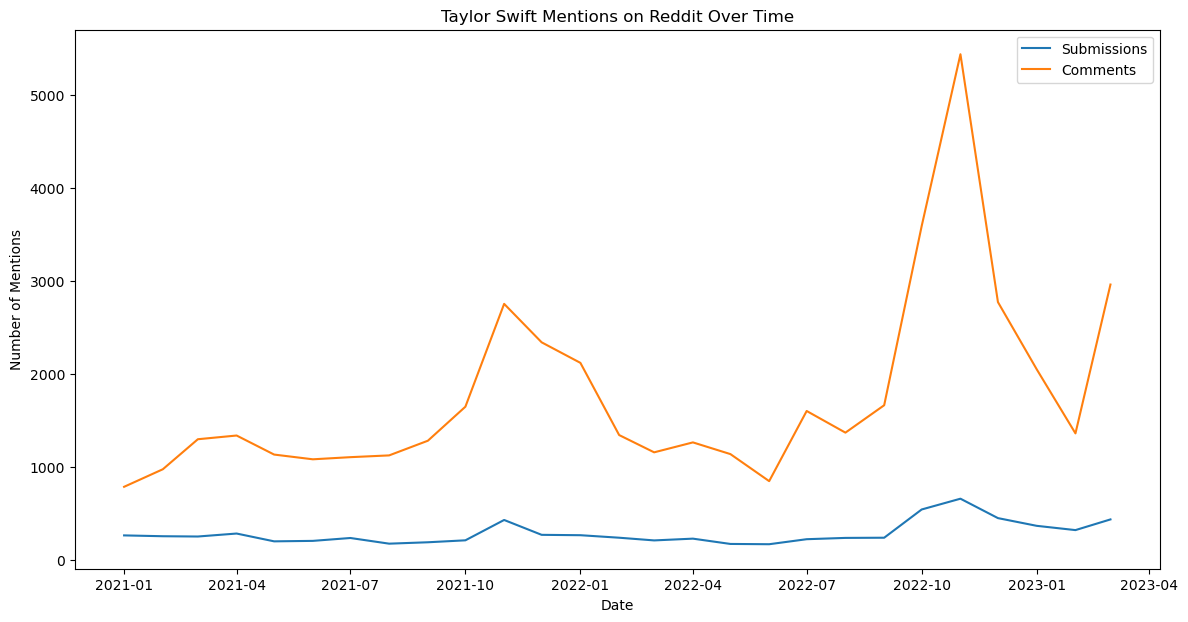

In [53]:
# Convert Spark DataFrame to Pandas for plotting

# Assuming the Pandas DataFrames are sorted by year and month, plot the time series
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.plot(ts_mentions_by_month_submissions_pd['date'], ts_mentions_by_month_submissions_pd['count'], label='Submissions')
plt.plot(ts_mentions_by_month_comments_pd['date'], ts_mentions_by_month_comments_pd['count'], label='Comments')
plt.xlabel('Date')
plt.ylabel('Number of Mentions')
plt.title('Taylor Swift Mentions on Reddit Over Time')
plt.legend()
plt.savefig('../data/plots/mengfei_eda_taylor_swift_mentions_monthly.png', dpi=300, bbox_inches='tight')
plt.show()


### Analysis

When examining both the observations and the discussions, on Reddit about Taylor Swift we can gain an understanding of her impact and how she engages with the public.

From January 2021 to April 2023 the mentions of Taylor Swift on Reddit indicate a level of interest particularly during important moments in her career. The data reveals that posts related to these moments experience spikes and variation suggesting that they are influenced by real time events. The overall pattern of posts is quite volatile with trend lines indicating fluctuating levels of engagement over time.

Notable events such as the release of "Fearless (Taylors Version)" in April 2021 and "Red (Taylors Version)" in November 2021 sparked discussions about rights. Demonstrated Swifts ability to revisit her catalog with both critical acclaim and commercial success. These re recorded albums not dominated the charts. Also set new sales records influencing broader conversations within the music industry.

The peak in November 2022 coincided with a controversy surrounding Ticketmaster during the sale of tickets for Swifts Eras Tour. This incident generated a spike in mentions. The ticket sales debacle resulted in website crashes and poor customer service due, to demand, which garnered media coverage ignited public debates and even attracted government attention.This issue brings attention to the relationship, between entertainment, business strategies and government intervention demonstrating Swifts impact extending beyond the music sector.

In order to gain an understanding of the discussions, about Taylor Swift on Reddit we can use sentiment analysis to determine the sentiment (positive, negative or neutral) of these mentions.

By exploring the data from Reddit and interpreting Taylor Swifts impact, on the platform we can see how her professional achievements and associated controversies resonate with the public. This showcases the range of her influence, which not shapes cultural narratives and industry practices but also sparks political conversations. These aspects are vividly captured through social media engagement.

